In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, LSTM, GRU, Dense, Attention, Add, LayerNormalization, Dropout, GlobalAveragePooling1D
import keras_tuner as kt

figsize = (16,4)
plt.rcParams['figure.figsize'] = figsize
pd.set_option('display.float_format', lambda x: '%.2f' % x)


sentiments = pd.read_parquet('/kaggle/input/news-sentiment-aggs/news-sentiment-aggs.parquet')
stocks = pd.read_parquet('/kaggle/input/stock-sentiment-features/stock-history-features.parquet')
stocks_full = pd.read_parquet('/kaggle/input/stock-sentiment-features/stock-history-features-full.parquet')

display(sentiments.sample(5))
display(stocks.sample(5))
display(stocks_full.sample(5))

,stock,date,title_pos,title_neg,title_neu,summary_pos,summary_neg,summary_neu
1519,GOOG,2023-12-26,0.13,0.04,0.83,0.19,0.11,0.70
2260,TSLA,2023-09-04,0.14,0.06,0.80,0.14,0.08,0.77
1323,GOOG,2023-06-13,0.13,0.14,0.73,0.15,0.13,0.72
324,AAPL,2023-01-19,0.15,0.26,0.60,0.15,0.25,0.60
2464,TSLA,2024-03-26,0.17,0.11,0.72,0.21,0.16,0.63


,date,stock,day_of_week,day,month,year,lag_1,lag_2,rolling_mean_7,rolling_mean_14,close
1442,2023-03-24,GOOG,4,24,3,2023,106.14,104.10,103.86,98.66,105.94
557,2024-05-17,TSLA,4,17,5,2024,174.84,173.99,173.74,177.00,177.46
718,2022-09-07,AAPL,2,7,9,2022,153.01,154.28,155.85,161.50,154.43
608,2022-03-30,AAPL,2,30,3,2022,176.70,173.38,172.10,164.34,175.52
1717,2024-04-29,GOOG,0,29,4,2024,173.49,157.77,161.85,159.71,167.71


,date,stock,day_of_week,day,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_7,rolling_std_7,rolling_mean_14,close,rolling_std_14
145,2022-09-27,TSLA,1,27,9,2022,276.01,275.33,288.59,300.80,308.73,309.07,303.35,291.64,14.58,295.48,282.94,11.46
1575,2023-10-04,GOOG,2,4,10,2023,133.15,135.02,131.70,132.98,131.31,129.30,132.02,132.80,2.30,133.85,136.12,3.09
1649,2024-01-22,GOOG,0,22,1,2024,147.80,144.83,142.73,143.92,144.08,143.51,143.64,144.91,1.99,142.54,147.54,3.21
316,2023-06-02,TSLA,4,2,6,2023,207.52,203.93,201.16,193.17,184.47,182.90,185.77,198.16,11.73,187.54,213.97,14.85
977,2023-09-19,AAPL,1,19,9,2023,177.27,174.32,175.05,173.52,175.61,178.65,177.48,176.11,2.01,180.07,178.36,5.59


In [22]:
stocks_full.insert(17, 'close', stocks_full.pop('close'))

## Filter and Concatenate Datasets

In [23]:
print(
f"""Range of dates:
    Stocks: {stocks.date.min()} - {stocks.date.max()}
    Sentiments: {sentiments.date.min()} - {sentiments.date.max()}"""
)

stock_dates = set(stocks.date)
sent_dates = set(sentiments.date)

print(
f"""Number of dates:
    Stocks: {len(stock_dates)}
    Sentiments: {len(sent_dates)}"""
)

diff = pd.to_datetime(list(sent_dates.difference(stock_dates)))
diff.day_of_week.value_counts()

Range of dates:
    Stocks: 2022-03-01 - 2024-07-01
    Sentiments: 2022-03-01 - 2024-07-01
Number of dates:
    Stocks: 587
    Sentiments: 854


6    122
5    122
0     16
4      3
3      2
1      1
2      1
Name: count, dtype: int64

In [24]:
# df = sentiments.merge(stocks, how='inner', on=['date', 'stock'])
df = sentiments.merge(stocks_full, how='inner', on=['date', 'stock'])
df = df.set_index('date')
df.sample(5)

,stock,title_pos,title_neg,title_neu,summary_pos,summary_neg,summary_neu,day_of_week,day,month,...,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,close
date,,,,,,,,,,,,,,,,,,,,,
2023-01-13,AAPL,0.15,0.30,0.55,0.14,0.28,0.57,4,13,1,...,129.66,129.09,128.56,124.00,125.33,129.96,3.25,128.66,3.11,133.66
2022-09-23,TSLA,0.11,0.26,0.64,0.19,0.22,0.60,4,23,9,...,308.73,309.07,303.35,303.75,302.61,298.52,12.30,295.42,11.61,275.33
2023-01-27,GOOG,0.12,0.13,0.75,0.14,0.16,0.70,4,27,1,...,99.10,101.09,99.17,93.80,91.68,98.49,2.51,94.83,4.30,100.60
2022-03-11,TSLA,0.15,0.22,0.63,0.18,0.14,0.68,4,11,3,...,274.80,268.19,279.43,279.76,293.30,276.15,7.36,276.43,10.91,265.12
2024-06-04,AAPL,0.14,0.13,0.73,0.15,0.21,0.64,1,4,6,...,191.29,190.29,189.99,189.98,186.88,191.74,1.86,190.91,1.91,194.35


## Data Preparation

In [25]:
class StockData:
    def __init__(self, stock, data, look_back=30, test_size=0.2):
        self.stock = stock
        self.data = data.query(f"stock == '{stock}'").copy()
        self.index = self.data.index
        self.data.drop("stock", axis=1, inplace=True)
        self.look_back = look_back
        self.test_size = test_size
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
        self.X = self.data.values
        self.y = self.data['close'].values.reshape(-1, 1)
        
        self.X_scaled = self.x_scaler.fit_transform(self.X)
        self.y_scaled = self.y_scaler.fit_transform(self.y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_sequence()

    def create_sequences(self, data):
        input_data = []
        target_data = []
        for i in range(len(data[0]) - self.look_back):
            input_seq = data[0][i:i+self.look_back]
            input_data.append(input_seq)

            target_value = data[1][i+self.look_back]
            target_data.append(target_value)
        return np.array(input_data), np.array(target_data)
        
    def split_sequence(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X_scaled, self.y_scaled, 
                                                            test_size=self.test_size, 
                                                            shuffle=False)
        
        X_train, y_train = self.create_sequences([X_train, y_train])
        X_test, y_test = self.create_sequences([X_test, y_test])
        
        return X_train, X_test, y_train, y_test
    
    def inverse_transform(self, data, scaler='y'):
        scaler_dict = {
            'x': self.x_scaler,
            'y': self.y_scaler
        }
        data_inv = scaler_dict[scaler].inverse_transform(data)
        
        return data_inv
    
    def plot(self):
        data = self.data
        split = int(len(data) * (1 - self.test_size))

        plt.plot(data.iloc[:split, -1], label='Training data')
        plt.plot(data.iloc[split:, -1], label='Test data')
        plt.xlabel("Date")
        plt.title("Stock Price")
        plt.legend()
        plt.show()
        plt.show()

In [26]:
TSLA = StockData("TSLA", df)
AAPL = StockData("AAPL", df)
GOOG = StockData("GOOG", df)

## Hypermodels

In [27]:
class GRUHyperModel(kt.HyperModel):
    def __init__(self):
        self.model = "GRU"
    def build(self, hp):
        model = Sequential()
        
        # Hyperparameter settings
        num_gru_layers = hp.Int("num_gru_layers", 1, 3)
        gru_units = [hp.Int(f"gru_units_{i}", min_value=25, max_value=200, step=25) for i in range(num_gru_layers)]
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        # Input Layer
        model.add(Input(shape=(self.look_back, self.input_shape)))
        
        # Add GRU layers
        for i in range(num_gru_layers):
            model.add(
                GRU(
                    units=gru_units[i],
                    return_sequences=True if i < num_gru_layers - 1 else False
                )
            )
        
        # Add Output layer
        model.add(Dense(1))

        # Optimizer
        opt = {
            'adam': tf.keras.optimizers.Adam,
            'rmsprop': tf.keras.optimizers.RMSprop,
        }

        # Compile model
        model.compile(
            optimizer=opt[optimizer_choice](learning_rate=learning_rate),
            loss='mse'
        )
        
        return model

In [28]:
class LSTMHyperModel(kt.HyperModel):
    def __init__(self):
        self.model = "LSTM"
        
    def build(self, hp):
        model = Sequential()
        
        # Hyperparameter settings
        num_lstm_layers = hp.Int("num_lstm_layers", 1, 3)
        lstm_units = [hp.Int(f"lstm_units_{i}", min_value=25, max_value=200, step=25) for i in range(num_lstm_layers)]
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        # Input Layer
        model.add(Input(shape=(self.look_back, self.input_shape)))
        
        # Add LSTM layers
        for i in range(num_lstm_layers):
            model.add(
                LSTM(
                    units=lstm_units[i],
                    return_sequences=True if i < num_lstm_layers - 1 else False
                )
            )
        
        # Add Output layer
        model.add(Dense(1))

        # Optimizer
        opt = {
            'adam': tf.keras.optimizers.Adam,
            'rmsprop': tf.keras.optimizers.RMSprop,
        }

        # Compile model
        model.compile(
            optimizer=opt[optimizer_choice](learning_rate=learning_rate),
            loss='mse'
        )
        
        return model

In [29]:
class AttentionCNNLSTMHyperModel(kt.HyperModel):
    def __init__(self):
        self.model = "Attention-CNNLSTM"
        
    def build(self, hp):
        model = Sequential()
        
        # Hyperparameter settings
        kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
        cnn_filters = hp.Int('cnn_filters', min_value=32, max_value=256, step=32)
        lstm_units = hp.Int('lstm_units', min_value=50, max_value=200, step=50)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        
        # Input Layer
        model.add(Input(shape=(self.look_back, self.input_shape)))
        
        # CNN Layers
        model.add(Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Conv1D(filters=cnn_filters * 2, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Conv1D(filters=cnn_filters * 4, kernel_size=kernel_size, activation='relu', padding='same'))
        
        # Attention Mechanism
        query = Dense(cnn_filters * 4)(model.layers[-1].output)
        key = Dense(cnn_filters * 4)(model.layers[-1].output)
        value = Dense(cnn_filters * 4)(model.layers[-1].output)
        attention_output = Attention()([query, key, value])
        
        # Add and Normalize
        add_output = Add()([model.layers[-1].output, attention_output])
        norm_output = LayerNormalization()(add_output)
        
        # LSTM Decoder
        model.add(LSTM(lstm_units, return_sequences=False))
        model.add(Dropout(dropout_rate))
        
        # Output Layer
        model.add(Dense(1))
        
        # Optimizer
        opt = {
            'adam': tf.keras.optimizers.Adam,
            'rmsprop': tf.keras.optimizers.RMSprop,
        }

        # Compile model
        model.compile(
            optimizer=opt[optimizer_choice](learning_rate=learning_rate),
            loss='mse'
        )
        
        return model

## Stock Model

In [30]:
class StockModel:
    def __init__(self, stock_data, hypermodel=None, max_trials=20, epochs=20, directory='models'):
        self.stock_data = stock_data
        self.directory = directory
        self.max_trials = max_trials
        self.epochs = epochs

        self.X_train = self.stock_data.X_train
        self.X_test = self.stock_data.X_test
        self.y_train = self.stock_data.y_train
        self.y_test = self.stock_data.y_test
        self.input_shape = self.X_train.shape[2]
        
        self.hypermodel = hypermodel if hypermodel else GRUHyperModel()
        self.hypermodel.look_back = self.stock_data.look_back
        self.hypermodel.input_shape = self.input_shape

        self.best_model = None
        self.best_hyperparameters = None
        
        self.rmse = None
        self.accuracy = None

    def train_best_model(self, monitor='val_loss', patience=5, min_delta=0):
        tuner = kt.RandomSearch(
            self.hypermodel,
            objective='val_loss',
            max_trials=self.max_trials,
            executions_per_trial=2,
            directory=f'{self.directory}',
            project_name=f'{self.stock_data.stock}/{self.hypermodel.model}'
        )

        stop_early = EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)

        tuner.search(self.X_train, self.y_train, epochs=self.epochs, validation_split=0.2, callbacks=[stop_early])
        
        self.best_model = tuner.get_best_models(num_models=1)[0]
        self.best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values
        
        return self.best_model

    def evaluate_model(self):
        y_true = self.y_test
        y_pred = self.best_model.predict(self.X_test)
        pred = self.stock_data.inverse_transform(y_pred, scaler='y')
        true = self.stock_data.inverse_transform(y_true, scaler='y')

        self.rmse = np.sqrt(mean_squared_error(true, pred))
        print(f"Root Mean Squared Error: {self.rmse:.2f} USD")
        
        self.accuracy = (1 - np.mean(np.abs((true - pred) / true))) * 100
        print(f"Model Accuracy: {self.accuracy:.2f}%")

        data = self.stock_data.data
        split = -pred.size

        plt.plot(data.index[split:], true, label='Test data')
        plt.plot(data.index[split:], pred, label='Predicted data', color='orange')
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.title(f"{self.stock_data.stock} Model Predictions")
        plt.legend()
        plt.show()
        
        plt.plot(data.index[:split], data.iloc[:split]['close'], label='Training data', color='lightgray')
        plt.plot(data.index[split:], true, label='Test data')
        plt.plot(data.index[split:], pred, label='Predicted data')
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.title(f"{self.stock_data.stock} Model Performance")
        plt.legend()
        plt.show()

In [31]:
# import shutil

# try:
#     shutil.rmtree('/kaggle/working/models')
# except:
#     pass

## TSLA

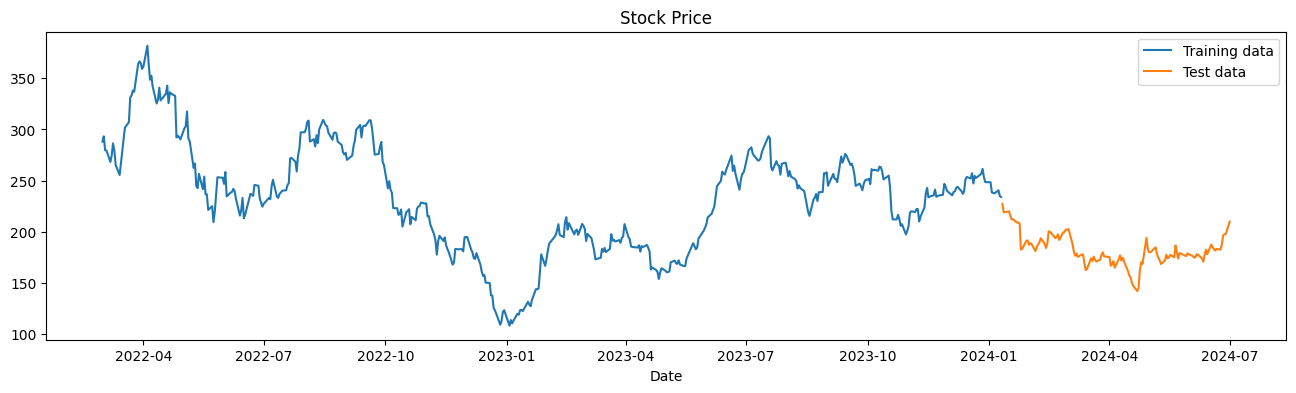

In [32]:
TSLA.plot()

In [33]:
tsla_lstm = StockModel(TSLA, LSTMHyperModel())
best_tsla_lstm = tsla_lstm.train_best_model()
best_tsla_lstm.summary()

Trial 20 Complete [00h 00m 11s]
val_loss: 0.003267867607064545

Best val_loss So Far: 0.002324711182154715
Total elapsed time: 00h 03m 34s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        49,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 125)            │       113,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,326 (634.09 KB)

 Trainable params: 162,326 (634.09 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
tsla_gru = StockModel(TSLA, GRUHyperModel())
best_tsla_gru = tsla_gru.train_best_model()
best_tsla_gru.summary()

Trial 20 Complete [00h 00m 12s]
val_loss: 0.005842530867084861

Best val_loss So Far: 0.001470010494813323
Total elapsed time: 00h 04m 15s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │        11,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,151 (43.56 KB)

 Trainable params: 11,151 (43.56 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Root Mean Squared Error: 10.95 USD
Model Accuracy: 95.01%


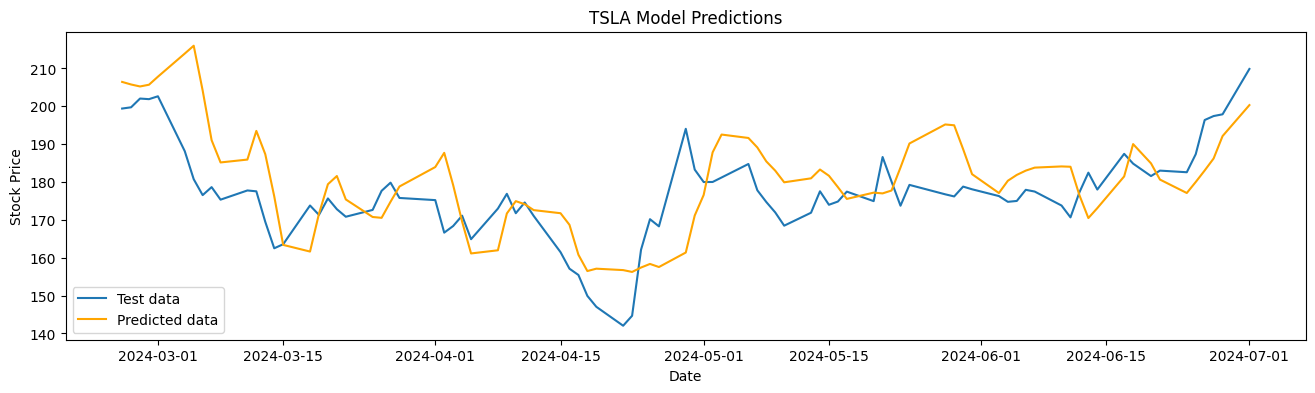

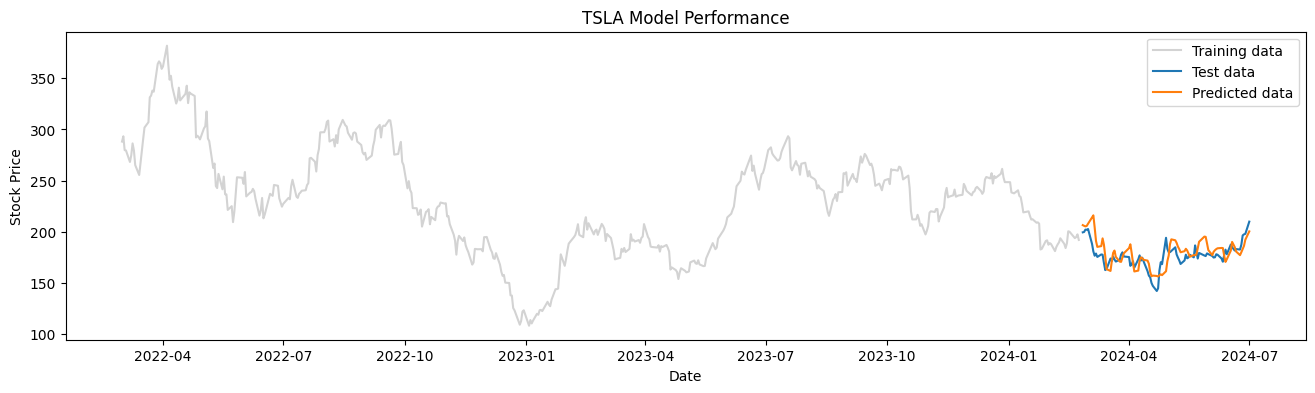

In [35]:
tsla_lstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Root Mean Squared Error: 7.65 USD
Model Accuracy: 96.74%


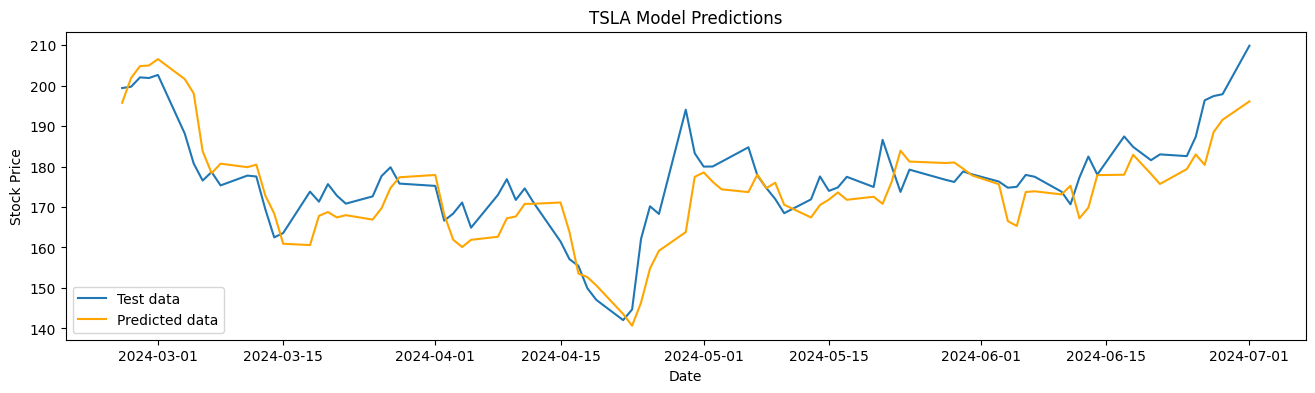

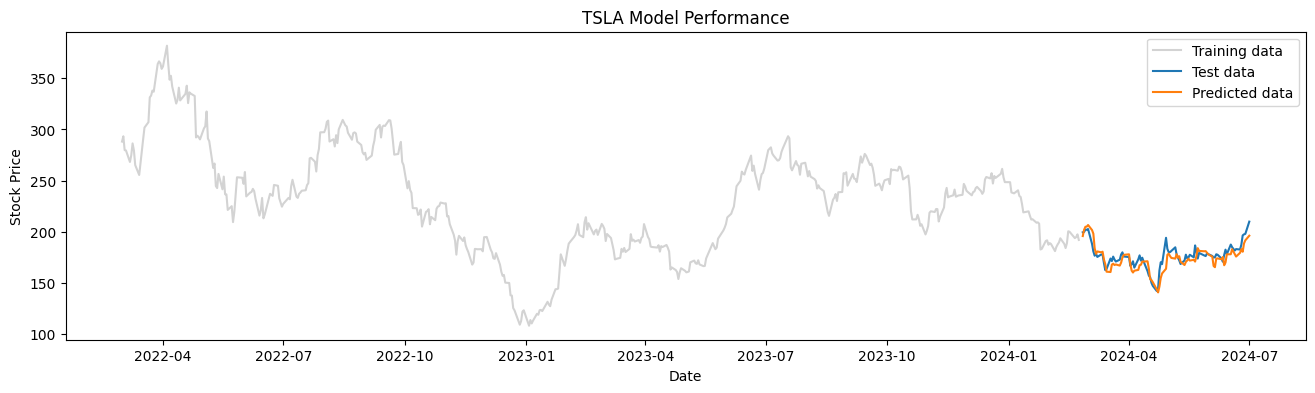

In [36]:
tsla_gru.evaluate_model()

## AAPL

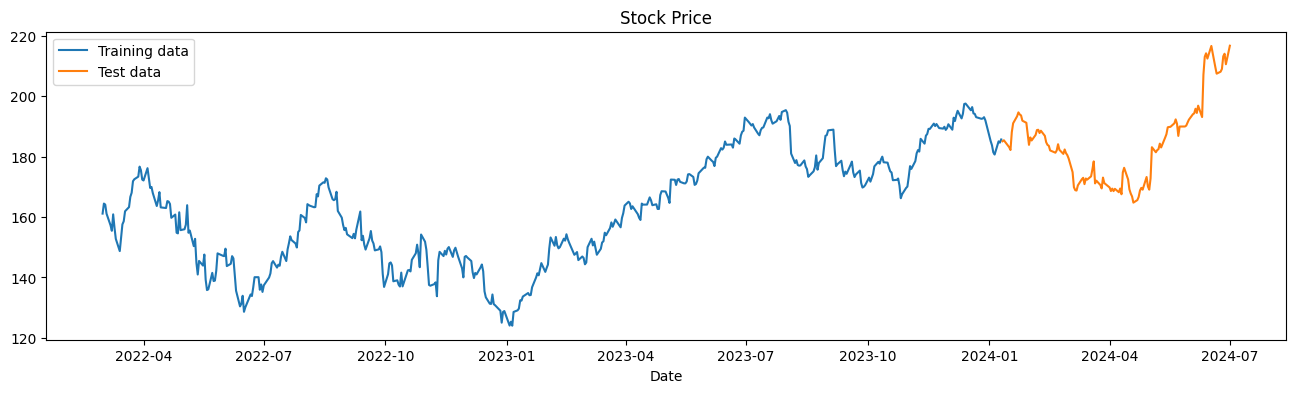

In [37]:
AAPL.plot()

In [38]:
aapl_lstm = StockModel(AAPL, LSTMHyperModel())
best_aapl_lstm = aapl_lstm.train_best_model()
best_aapl_lstm.summary()

Trial 20 Complete [00h 00m 20s]
val_loss: 0.0030691096326336265

Best val_loss So Far: 0.0020747355883941054
Total elapsed time: 00h 04m 47s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 75)             │        29,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,476 (115.14 KB)

 Trainable params: 29,476 (115.14 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
aapl_gru = StockModel(AAPL, GRUHyperModel())
best_aapl_gru = aapl_gru.train_best_model()
best_aapl_gru.summary()

Trial 20 Complete [00h 00m 16s]
val_loss: 0.0034978125477209687

Best val_loss So Far: 0.0015379932592622936
Total elapsed time: 00h 05m 03s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        55,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,001 (218.75 KB)

 Trainable params: 56,001 (218.75 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Root Mean Squared Error: 6.10 USD
Model Accuracy: 97.52%


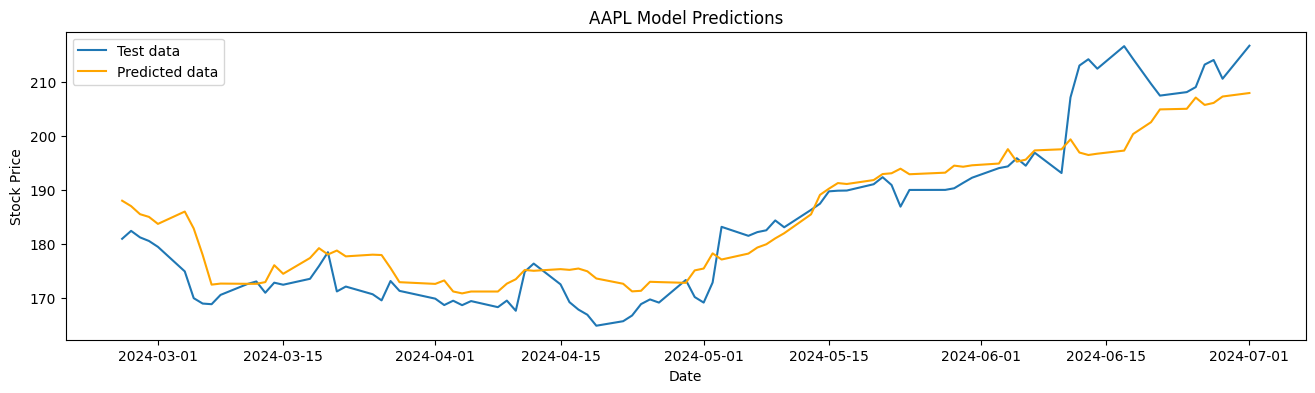

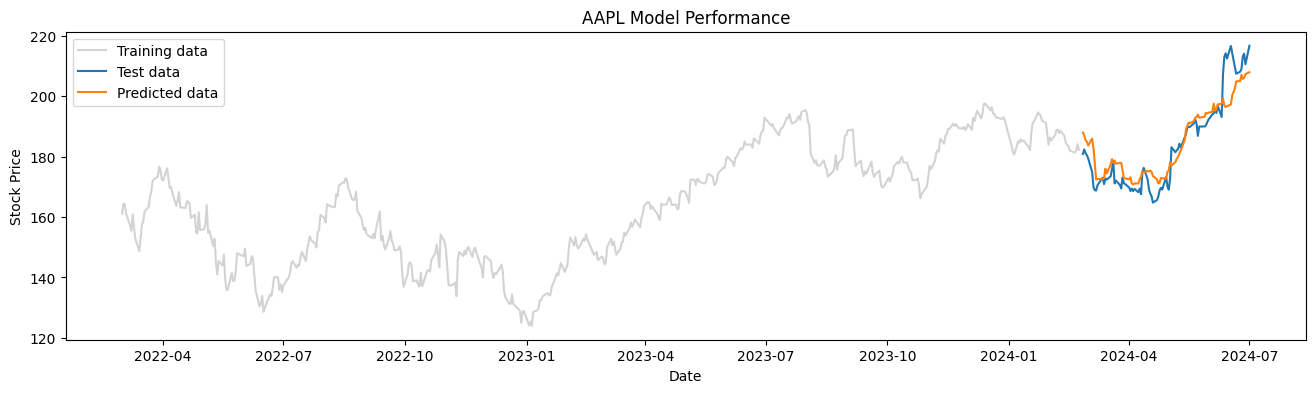

In [40]:
aapl_lstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Root Mean Squared Error: 4.85 USD
Model Accuracy: 97.92%


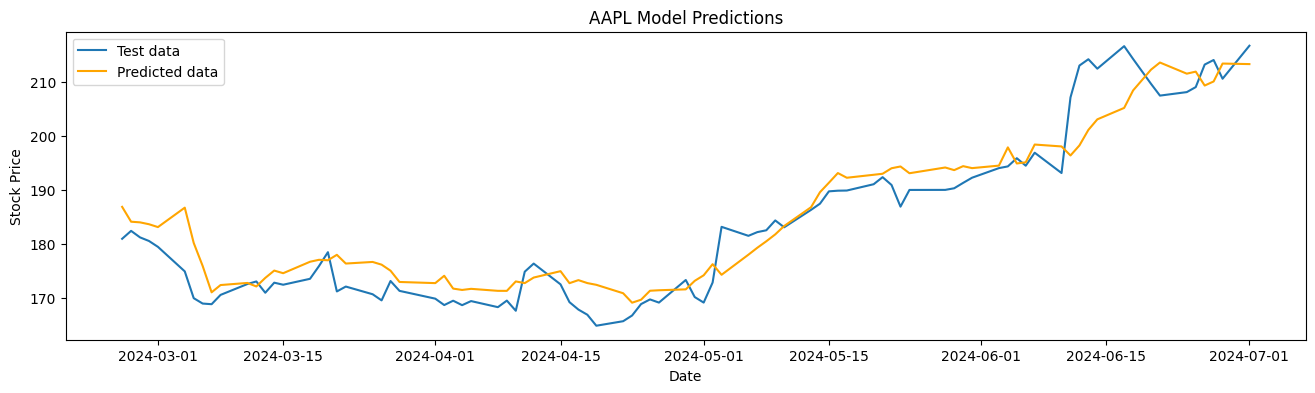

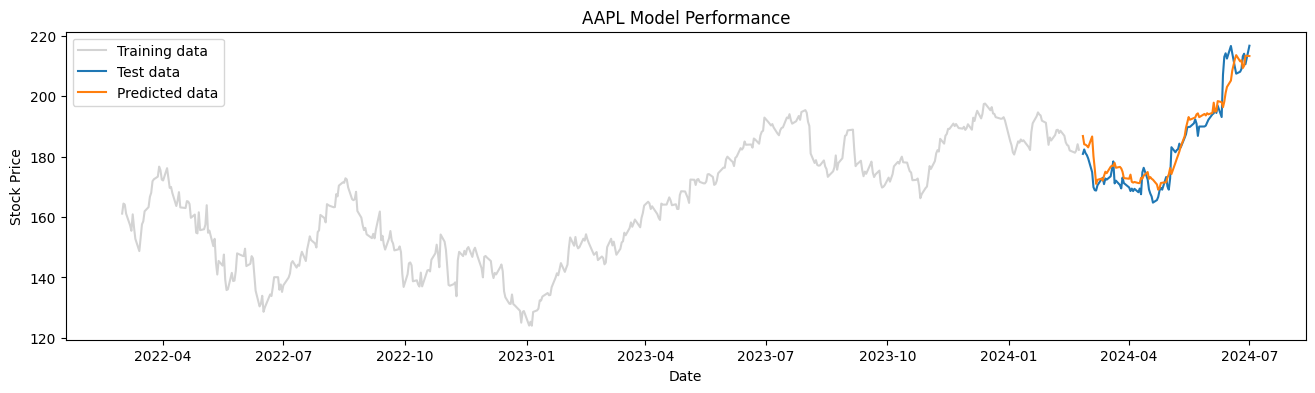

In [41]:
aapl_gru.evaluate_model()

## GOOG

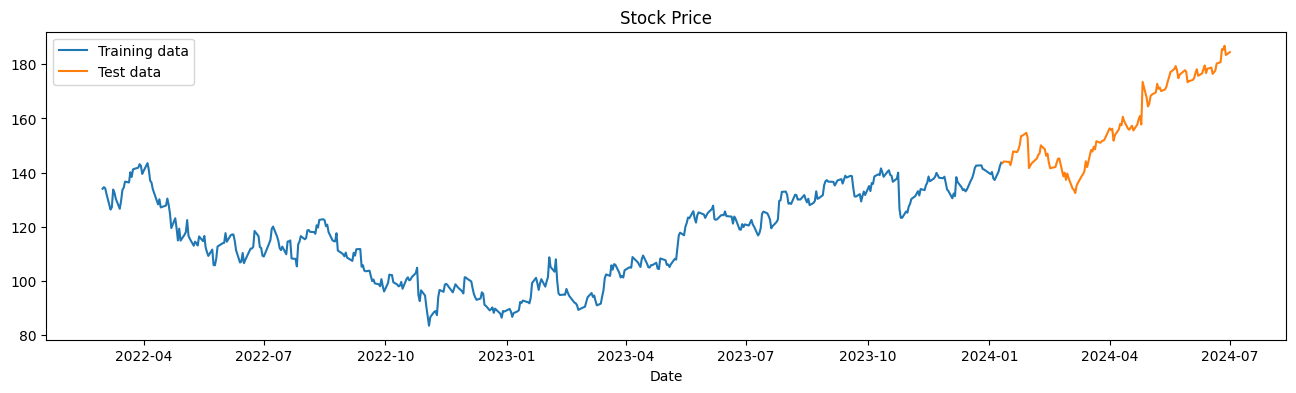

In [42]:
GOOG.plot()

In [43]:
goog_lstm = StockModel(GOOG, LSTMHyperModel())
best_goog_lstm = goog_lstm.train_best_model()
best_goog_lstm.summary()

Trial 20 Complete [00h 00m 15s]
val_loss: 0.0014001522795297205

Best val_loss So Far: 0.0014001522795297205
Total elapsed time: 00h 05m 26s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,826 (18.85 KB)

 Trainable params: 4,826 (18.85 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
goog_gru = StockModel(GOOG, GRUHyperModel())
best_goog_gru = goog_gru.train_best_model()
best_goog_gru.summary()

Trial 20 Complete [00h 00m 14s]
val_loss: 0.016997963190078735

Best val_loss So Far: 0.0010869086836464703
Total elapsed time: 00h 05m 25s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 150)            │        78,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,451 (306.45 KB)

 Trainable params: 78,451 (306.45 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Root Mean Squared Error: 15.13 USD
Model Accuracy: 92.16%


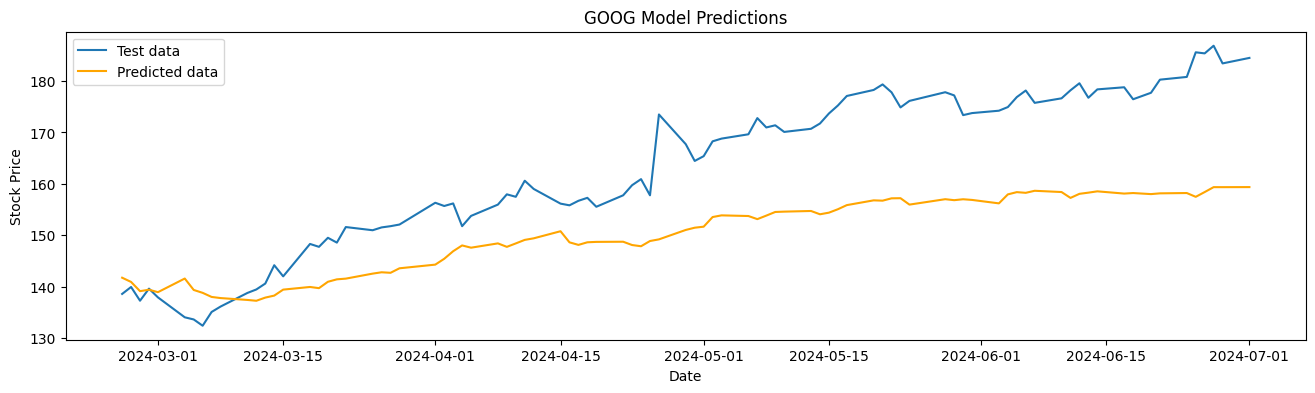

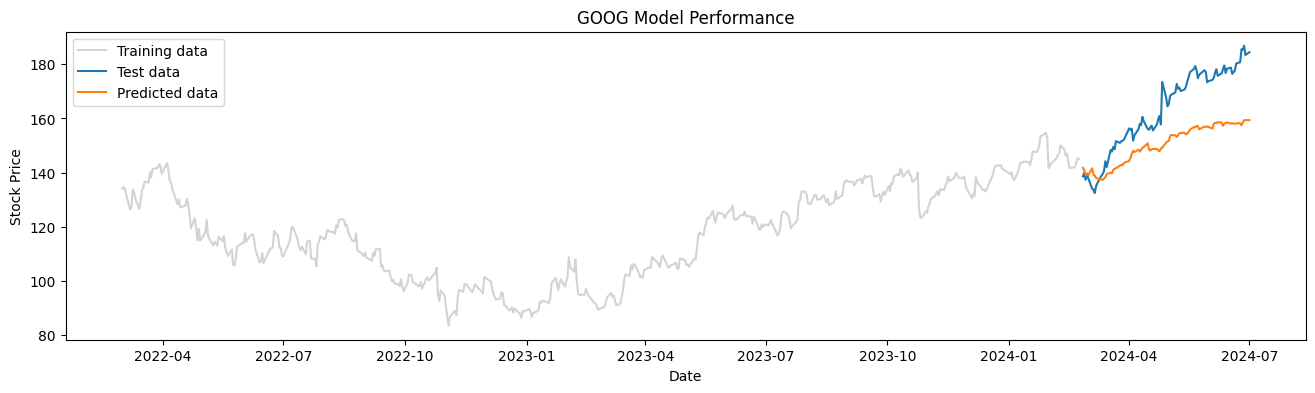

In [45]:
goog_lstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Root Mean Squared Error: 3.42 USD
Model Accuracy: 98.35%


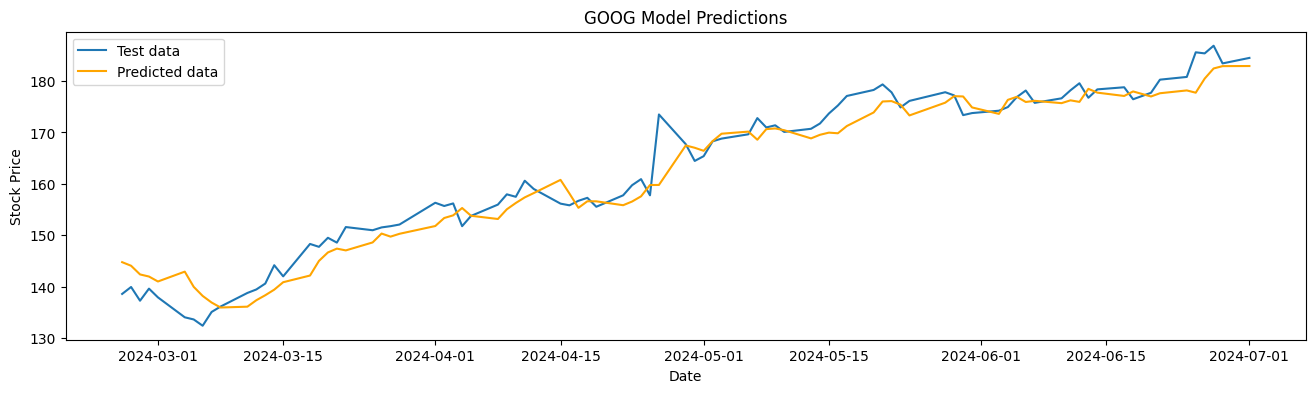

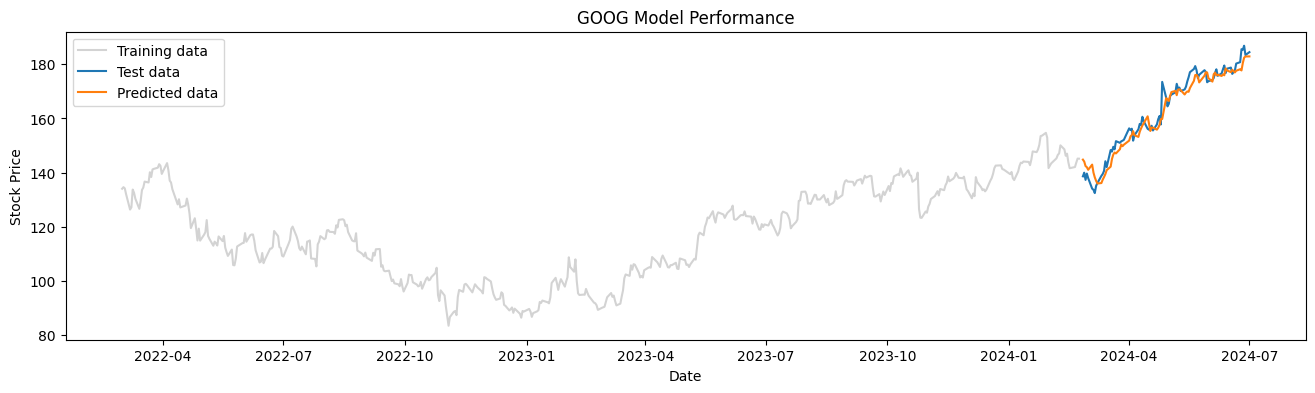

In [46]:
goog_gru.evaluate_model()

## Attention-based CNN-LSTM

In [47]:
tsla_acnnlstm = StockModel(TSLA, AttentionCNNLSTMHyperModel())
best_tsla_acnnlstm = tsla_acnnlstm.train_best_model()
best_tsla_acnnlstm.summary()

Trial 20 Complete [00h 00m 19s]
val_loss: 0.0042791294399648905

Best val_loss So Far: 0.002627477399073541
Total elapsed time: 00h 06m 18s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,795 (354.67 KB)

 Trainable params: 90,795 (354.67 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
aapl_acnnlstm = StockModel(AAPL, AttentionCNNLSTMHyperModel())
best_aapl_acnnlstm = aapl_acnnlstm.train_best_model()
best_aapl_acnnlstm.summary()

Trial 20 Complete [00h 00m 20s]
val_loss: 0.004537454340606928

Best val_loss So Far: 0.002255849656648934
Total elapsed time: 00h 07m 14s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 256)        │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 1024)       │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       705,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689,919 (10.26 MB)

 Trainable params: 2,689,919 (10.26 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
goog_acnnlstm = StockModel(GOOG, AttentionCNNLSTMHyperModel())
best_goog_acnnlstm = goog_acnnlstm.train_best_model()
best_goog_acnnlstm.summary()

Trial 20 Complete [00h 00m 22s]
val_loss: 0.0021816150983795524

Best val_loss So Far: 0.001633917447179556
Total elapsed time: 00h 07m 25s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 96)         │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 192)        │        55,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 384)        │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │       194,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,589 (1.82 MB)

 Trainable params: 477,589 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Root Mean Squared Error: 19.87 USD
Model Accuracy: 89.59%


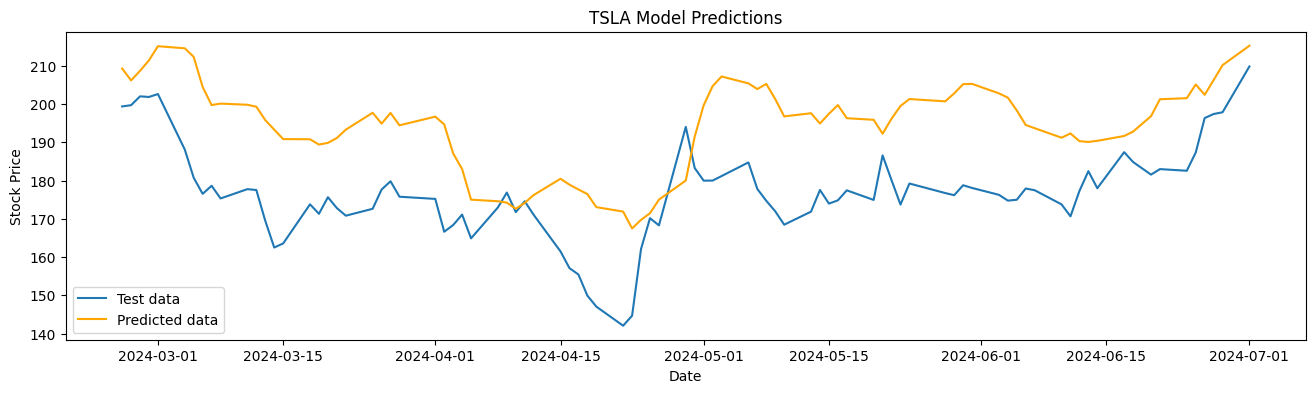

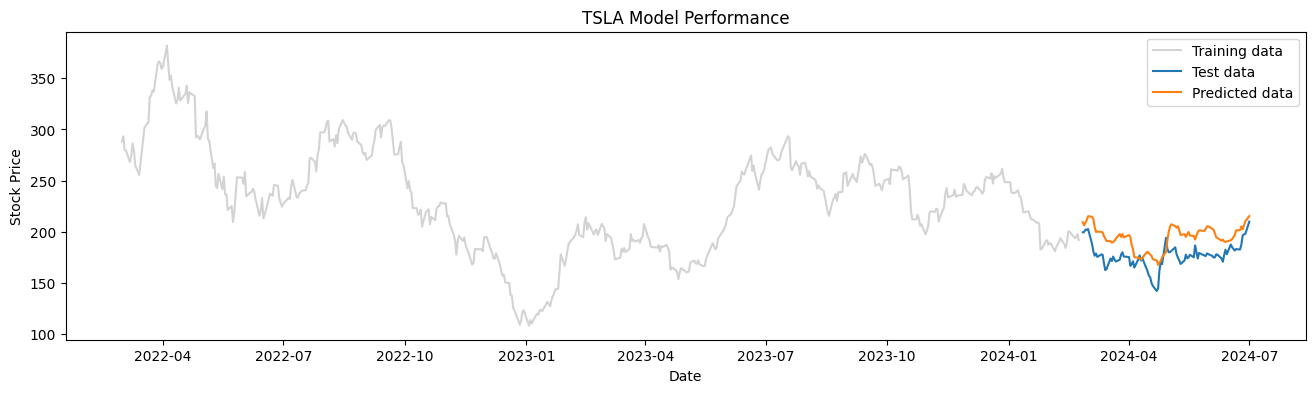

In [50]:
tsla_acnnlstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Root Mean Squared Error: 6.62 USD
Model Accuracy: 97.37%


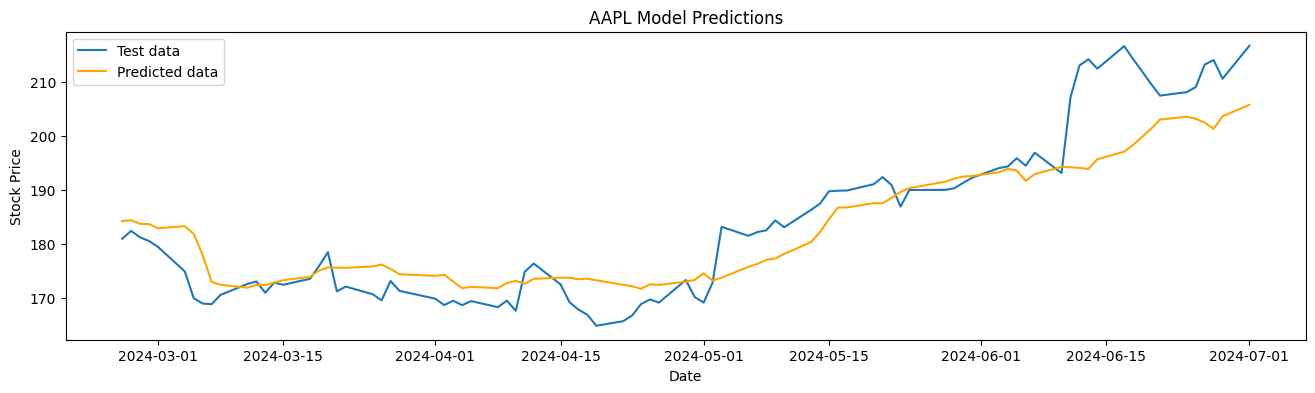

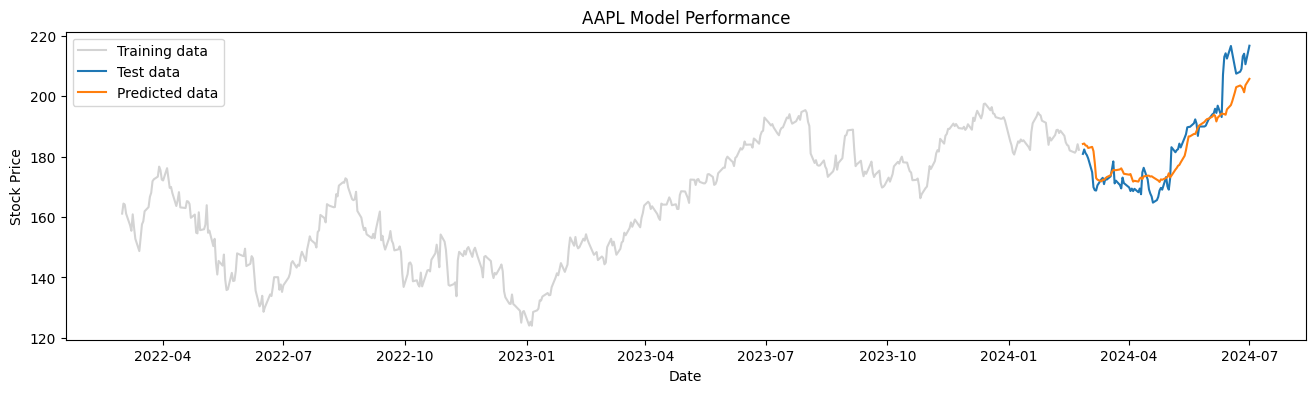

In [51]:
aapl_acnnlstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Root Mean Squared Error: 10.18 USD
Model Accuracy: 94.41%


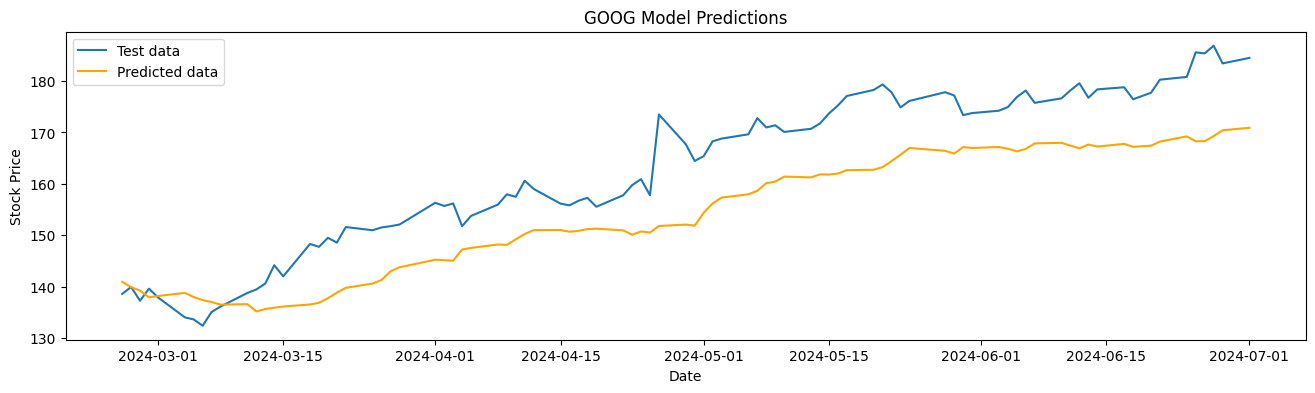

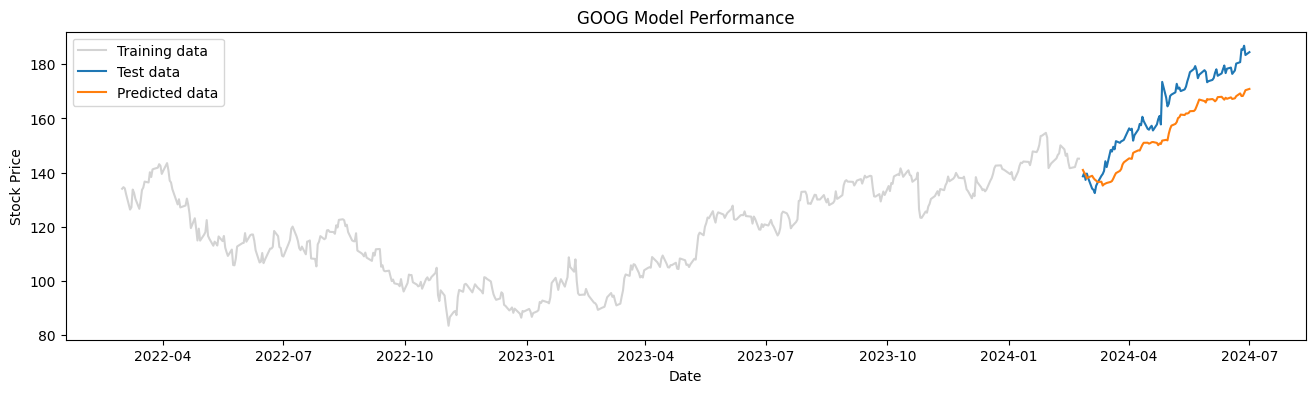

In [52]:
goog_acnnlstm.evaluate_model()

## Evaluation

In [53]:
models = dict(
    tsla_lstm = tsla_lstm, 
    tsla_gru = tsla_gru,
    aapl_lstm = aapl_lstm,
    aapl_gru = aapl_gru,
    goog_lstm = goog_lstm, 
    goog_gru = goog_gru,
    tsla_acnnlstm = tsla_acnnlstm,
    aapl_acnnlstm = aapl_acnnlstm,
    goog_acnnlstm = goog_acnnlstm,
)

results = pd.DataFrame()

for k, v in models.items():
    stock, model = k.split('_')
    params = v.best_hyperparameters
    accuracy = v.accuracy
    rmse = v.rmse
    
    data = pd.DataFrame(params, index=[len(results)])
    data['Model'] = model.upper()
    data['Stock'] = stock.upper()
    data['Accuracy'] = accuracy
    data['RMSE'] = rmse
    
    results = pd.concat([results, data], ignore_index=True)
    
results['num_layers'] = results['num_lstm_layers'].fillna(results['num_gru_layers'])
results['units_0'] = results['lstm_units_0'].fillna(results['gru_units_0'])
results['units_1'] = results['lstm_units_1'].fillna(results['gru_units_1'])
results['units_2'] = results['lstm_units_2'].fillna(results['gru_units_2'])
results.drop(['num_lstm_layers', 'num_gru_layers', 'lstm_units_0', 'gru_units_0',
             'lstm_units_1', 'gru_units_1', 'lstm_units_2', 'gru_units_2'], axis=1, inplace=True)

results = results[['Stock', 'Model', 'Accuracy', 'RMSE', 'num_layers', 'units_0', 'units_1', 'units_2', 
                    'optimizer', 'learning_rate', 'cnn_filters', 'kernel_size']]

display(results)

,Stock,Model,Accuracy,RMSE,num_layers,units_0,units_1,units_2,optimizer,learning_rate,cnn_filters,kernel_size
0,TSLA,LSTM,95.01,10.95,2.00,100.00,125.00,75.00,adam,0.01,NaN,NaN
1,TSLA,GRU,96.74,7.65,1.00,50.00,75.00,175.00,adam,0.01,NaN,NaN
2,AAPL,LSTM,97.52,6.10,1.00,75.00,NaN,NaN,adam,0.01,NaN,NaN
3,AAPL,GRU,97.92,4.85,1.00,125.00,NaN,NaN,adam,0.01,NaN,NaN
4,GOOG,LSTM,92.16,15.13,1.00,25.00,150.00,50.00,adam,0.01,NaN,NaN
5,GOOG,GRU,98.35,3.42,1.00,150.00,100.00,175.00,adam,0.00,NaN,NaN
6,TSLA,ACNNLSTM,89.59,19.87,NaN,NaN,NaN,NaN,adam,0.00,32.00,5.00
7,AAPL,ACNNLSTM,97.37,6.62,NaN,NaN,NaN,NaN,adam,0.00,256.00,3.00
8,GOOG,ACNNLSTM,94.41,10.18,NaN,NaN,NaN,NaN,adam,0.00,96.00,3.00


In [54]:
results.to_csv('finbert-rnn-results.csv')

In [56]:
!zip -r file.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/models/ (stored 0%)
updating: kaggle/working/models/GOOG/ (stored 0%)
updating: kaggle/working/models/GOOG/GRU/ (stored 0%)
updating: kaggle/working/models/GOOG/GRU/trial_11/ (stored 0%)
updating: kaggle/working/models/GOOG/GRU/trial_11/build_config.json (stored 0%)
updating: kaggle/working/models/GOOG/GRU/trial_11/checkpoint.weights.h5 (deflated 11%)
updating: kaggle/working/models/GOOG/GRU/trial_11/trial.json (deflated 70%)
updating: kaggle/working/models/GOOG/GRU/trial_17/ (stored 0%)
updating: kaggle/working/models/GOOG/GRU/trial_17/build_config.json (stored 0%)
updating: kaggle/working/models/GOOG/GRU/trial_17/checkpoint.weights.h5 (deflated 11%)
updating: kaggle/working/models/GOOG/GRU/trial_17/trial.json (deflated 70%)
updating: kaggle/working/models/GOOG/GRU/tuner0.json (stored 0%)
updating: kaggle/working/models/GOOG/GRU/trial_14/ (stored 0%)
updating: kaggle